In [4]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Classifying Emotion in Audio Clips

Analyzing audio recordings and identify the emotions expressed in the speech

In [3]:
curr_dir = os.getcwd()

ravdess_path = os.path.join(curr_dir, "data_ravdess")
crema_path = os.path.join(curr_dir, "data_crema")
tess_path = os.path.join(curr_dir, "data_tess")
savee_path = os.path.join(curr_dir, "data_savee")

### Ravdess

The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

In [4]:
# ravdess key:value pairs 
emotions_convert = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear',
    '07': 'disgust',
    '08': 'surprise'
}

In [5]:
data = []

# Process files and store relevant data
for actor in os.listdir(ravdess_path):
    if 'Actor' in actor:
        actor_folder_path = os.path.join(ravdess_path, actor)
        for audio_file in os.listdir(actor_folder_path):
            file_name = audio_file.split('.')[0]
            parts = file_name.split('-')

            emotion_key = parts[2]
            gender_identifier = int(parts[6])
            gender = 'female' if gender_identifier % 2 == 0 else 'male'

            # Store each row's data as a dictionary
            data.append({
                'Path': os.path.join(actor_folder_path, audio_file),
                'Sex': gender,
                'Emotion': emotions_convert.get(emotion_key, 'Unknown')  # Use get to handle missing keys
            })

# Create DataFrame from the list of dictionaries
Ravdess_df = pd.DataFrame(data)

Ravdess_df

,Path,Sex,Emotion
0,/Users/gabrielcha/Documents/ser/data_ravdess/A...,female,angry
1,/Users/gabrielcha/Documents/ser/data_ravdess/A...,female,fear
2,/Users/gabrielcha/Documents/ser/data_ravdess/A...,female,fear
3,/Users/gabrielcha/Documents/ser/data_ravdess/A...,female,angry
4,/Users/gabrielcha/Documents/ser/data_ravdess/A...,female,disgust
...,...,...,...
1435,/Users/gabrielcha/Documents/ser/data_ravdess/A...,female,happy
1436,/Users/gabrielcha/Documents/ser/data_ravdess/A...,female,happy
1437,/Users/gabrielcha/Documents/ser/data_ravdess/A...,female,calm
1438,/Users/gabrielcha/Documents/ser/data_ravdess/A...,female,calm


### Crema

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [6]:
# crema key:value pairs 
emotion_mapping = {
    'SAD': 'sad',
    'ANG': 'angry',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral'
}

# actor's info
crema_actor_info = pd.read_csv('VideoDemographics.csv', usecols=['ActorID', 'Sex'])

In [7]:
data = []

# Process files and store relevant data
for file in os.listdir(crema_path):
    file_path = os.path.join(crema_path, file)
    parts = file.split('_')
    actor_info = parts[0]
    emotion_code = parts[2]

    # Append each row's data as a dictionary
    data.append({
        'Path': file_path,
        'ActorID': actor_info,
        'Emotion': emotion_mapping.get(emotion_code, 'Unknown')  # Handle unknown emotions
    })

# Create DataFrame from the list of dictionaries
Crema_df = pd.DataFrame(data)

# retrieve actor's info
Crema_df['ActorID'] = Crema_df['ActorID'].astype(int)
merged_df = pd.merge(Crema_df, crema_actor_info, left_on = 'ActorID', right_on = 'ActorID', how = 'left')
Crema_df = merged_df[['Path', 'Emotion', 'Sex']]
Crema_df['Sex'] = Crema_df['Sex'].str.lower()

Crema_df

,Path,Emotion,Sex
0,/Users/gabrielcha/Documents/ser/data_crema/102...,angry,male
1,/Users/gabrielcha/Documents/ser/data_crema/103...,angry,female
2,/Users/gabrielcha/Documents/ser/data_crema/106...,neutral,female
3,/Users/gabrielcha/Documents/ser/data_crema/107...,neutral,female
4,/Users/gabrielcha/Documents/ser/data_crema/107...,disgust,female
...,...,...,...
7437,/Users/gabrielcha/Documents/ser/data_crema/108...,angry,female
7438,/Users/gabrielcha/Documents/ser/data_crema/102...,angry,female
7439,/Users/gabrielcha/Documents/ser/data_crema/103...,angry,female
7440,/Users/gabrielcha/Documents/ser/data_crema/101...,angry,male


### Tess

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format



In [8]:
data = []

# Process files and store relevant data
for dir_name in os.listdir(tess_path):
    dir_path = os.path.join(tess_path, dir_name)
    for file in os.listdir(dir_path):
        # print(file)
        file_name = file.split('.')[0]
        parts = file_name.split('_')
        if len(parts) > 2:
            emotion_part = parts[2]
            if emotion_part=='ps': emotion = 'surprise'
            else: emotion = emotion_part
            # Append each row's data as a dictionary
            data.append({
                'Path': os.path.join(dir_path, file),
                'Emotion': emotion, 
                'Sex': 'female'
            })

# Create DataFrame from the list of dictionaries
Tess_df = pd.DataFrame(data)

Tess_df

,Path,Emotion,Sex
0,/Users/gabrielcha/Documents/ser/data_tess/YAF_...,disgust,female
1,/Users/gabrielcha/Documents/ser/data_tess/YAF_...,disgust,female
2,/Users/gabrielcha/Documents/ser/data_tess/YAF_...,disgust,female
3,/Users/gabrielcha/Documents/ser/data_tess/YAF_...,disgust,female
4,/Users/gabrielcha/Documents/ser/data_tess/YAF_...,disgust,female
...,...,...,...
2795,/Users/gabrielcha/Documents/ser/data_tess/OAF_...,sad,female
2796,/Users/gabrielcha/Documents/ser/data_tess/OAF_...,sad,female
2797,/Users/gabrielcha/Documents/ser/data_tess/OAF_...,sad,female
2798,/Users/gabrielcha/Documents/ser/data_tess/OAF_...,sad,female


### Savee 

The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. A neutral category is also added to provide recordings of 7 emotion categories.

In [9]:
# dictionary to map short emotion codes to full names
emotion_mapping = {
    'a': 'angry',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happy',
    'n': 'neutral',
    'sa': 'sad',
    'su': 'surprise'  
}

In [10]:
data = []


for file in os.listdir(savee_path):
    file_path = os.path.join(savee_path, file)
    part = file.split('_')[1][:-6]  # Get the emotion code, trimming the last 6 characters

    # Use the dictionary to get the full emotion name, default to 'surprise' if not found
    emotion = emotion_mapping.get(part, 'surprise')
    
    # Append each row's data as a dictionary
    data.append({
        'Path': file_path,
        'Emotion': emotion,
        'Sex' : 'male'
    })

# Create DataFrame from the list of dictionaries
Savee_df = pd.DataFrame(data)

Savee_df

,Path,Emotion,Sex
0,/Users/gabrielcha/Documents/ser/data_savee/JK_...,sad,male
1,/Users/gabrielcha/Documents/ser/data_savee/JK_...,sad,male
2,/Users/gabrielcha/Documents/ser/data_savee/DC_...,neutral,male
3,/Users/gabrielcha/Documents/ser/data_savee/DC_...,surprise,male
4,/Users/gabrielcha/Documents/ser/data_savee/DC_...,neutral,male
...,...,...,...
475,/Users/gabrielcha/Documents/ser/data_savee/JE_...,angry,male
476,/Users/gabrielcha/Documents/ser/data_savee/JE_...,angry,male
477,/Users/gabrielcha/Documents/ser/data_savee/DC_...,neutral,male
478,/Users/gabrielcha/Documents/ser/data_savee/DC_...,surprise,male


In [11]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
dataset = data_path.reset_index(drop=['index'])
dataset.to_csv("data_path.csv",index=False)
dataset['Emotion'] = dataset['Emotion'].replace('surprised', 'surprise')
dataset

,Path,Sex,Emotion
0,/Users/gabrielcha/Documents/ser/data_ravdess/A...,female,angry
1,/Users/gabrielcha/Documents/ser/data_ravdess/A...,female,fear
2,/Users/gabrielcha/Documents/ser/data_ravdess/A...,female,fear
3,/Users/gabrielcha/Documents/ser/data_ravdess/A...,female,angry
4,/Users/gabrielcha/Documents/ser/data_ravdess/A...,female,disgust
...,...,...,...
12157,/Users/gabrielcha/Documents/ser/data_savee/JE_...,male,angry
12158,/Users/gabrielcha/Documents/ser/data_savee/JE_...,male,angry
12159,/Users/gabrielcha/Documents/ser/data_savee/DC_...,male,neutral
12160,/Users/gabrielcha/Documents/ser/data_savee/DC_...,male,surprise


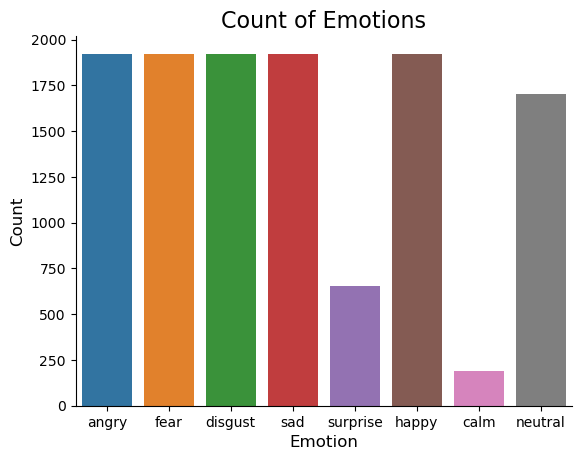

In [12]:
plt.title('Count of Emotions', size=16)
sns.countplot(dataset.Emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotion', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [13]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

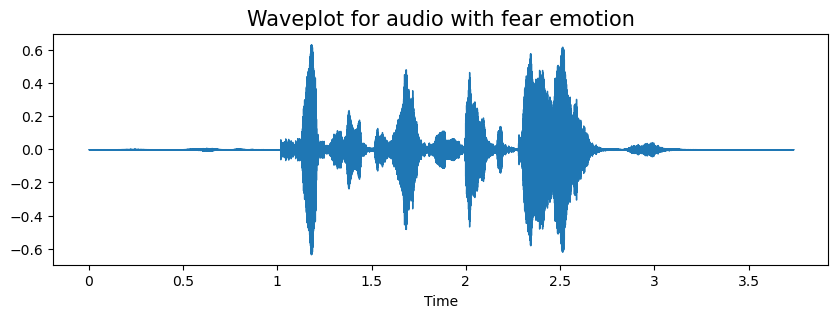

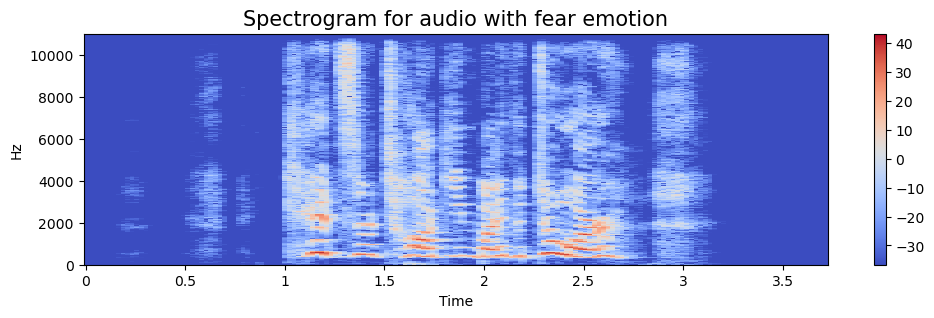

In [14]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


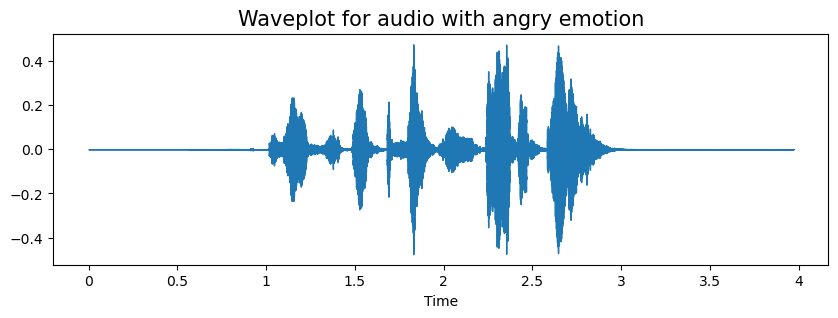

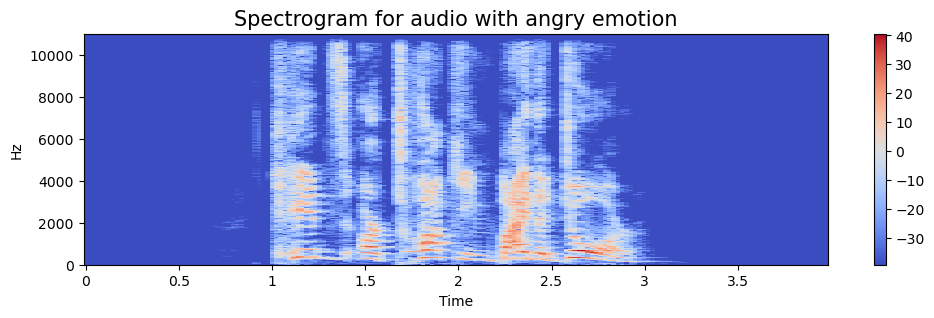

In [15]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

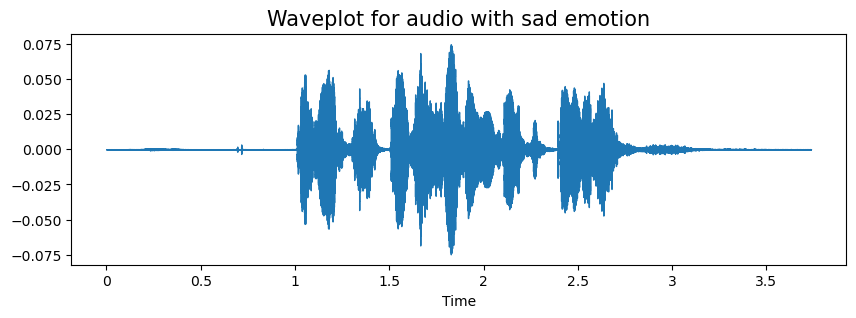

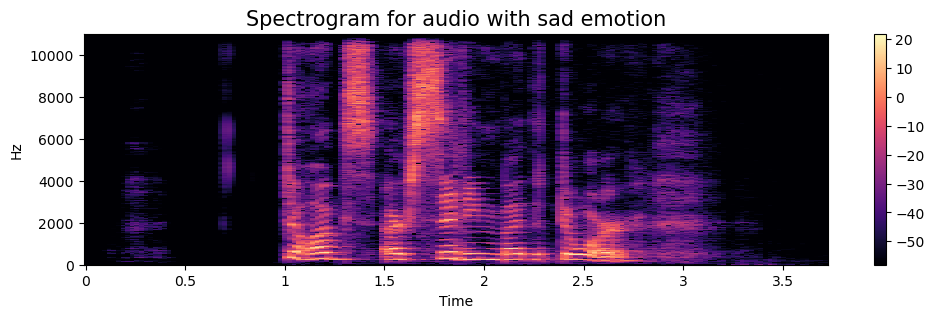

In [16]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

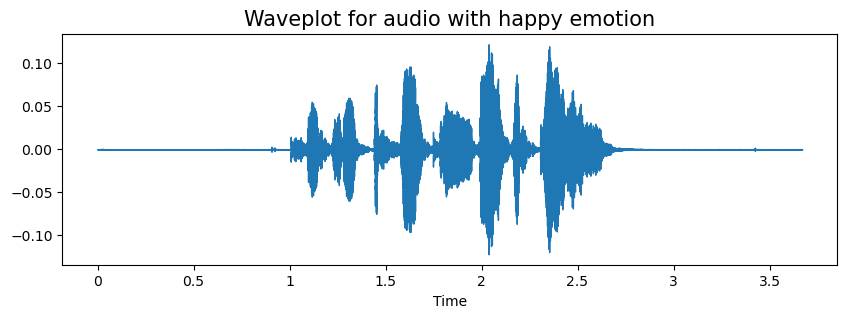

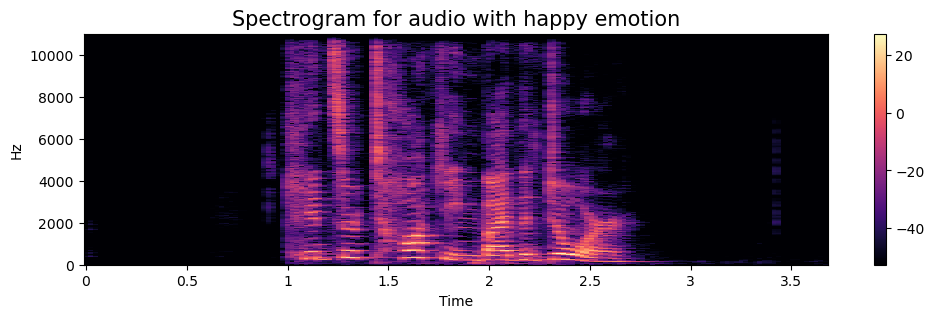

In [17]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Feature Extraction

In [6]:
Features = pd.read_csv('features.csv')
Features = Features.sample(frac=1).reset_index(drop=True) 
X = Features.iloc[: ,:-2]
Y = Features['labels_emotion'].values

In [7]:
# shuffling 
Features = Features.sample(frac=1).reset_index(drop=True) 

In [8]:
X = Features.iloc[: ,:-2]
Y = Features['labels_emotion'].values

In [9]:
encoder = OneHotEncoder()
# Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [10]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364,), (9122, 162), (9122,))

In [11]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364,), (9122, 162), (9122,))

In [12]:
from sklearn.svm import SVC
# SVM model
model = SVC(kernel='rbf', gamma='scale', C=1.0)
model.fit(x_train, y_train)

SVC()

In [13]:
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Evaluate the model
y_pred = model.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy:  0.5734488050866038
Classification Report:
               precision    recall  f1-score   support

       angry       0.74      0.70      0.72      1495
        calm       0.42      0.72      0.53       141
     disgust       0.43      0.50      0.46      1437
        fear       0.63      0.40      0.49      1396
       happy       0.54      0.50      0.52      1403
     neutral       0.55      0.55      0.55      1274
         sad       0.55      0.70      0.61      1486
    surprise       0.77      0.76      0.76       490

    accuracy                           0.57      9122
   macro avg       0.58      0.60      0.58      9122
weighted avg       0.58      0.57      0.57      9122



In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC


# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, cv=5, n_jobs=-1)
grid.fit(x_train, y_train)

# Print best parameters
print(f"Best parameters found: {grid.best_params_}")

# Evaluate the best model
y_pred = grid.best_estimator_.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters found: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy:  0.7372286779215085
Classification Report:
               precision    recall  f1-score   support

       angry       0.63      0.91      0.75      1495
        calm       0.94      0.84      0.88       141
     disgust       0.72      0.69      0.71      1437
        fear       0.75      0.59      0.66      1396
       happy       0.76      0.66      0.71      1403
     neutral       0.78      0.74      0.76      1274
         sad       0.76      0.77      0.76      1486
    surprise       0.96      0.85      0.90       490

    accuracy                           0.74      9122
   macro avg       0.79      0.76      0.77      9122
weighted avg       0.75      0.74      0.74      9122

[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.486 total time= 3.4min
[CV 3/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.411 total time= 3.5min
[CV 5/5

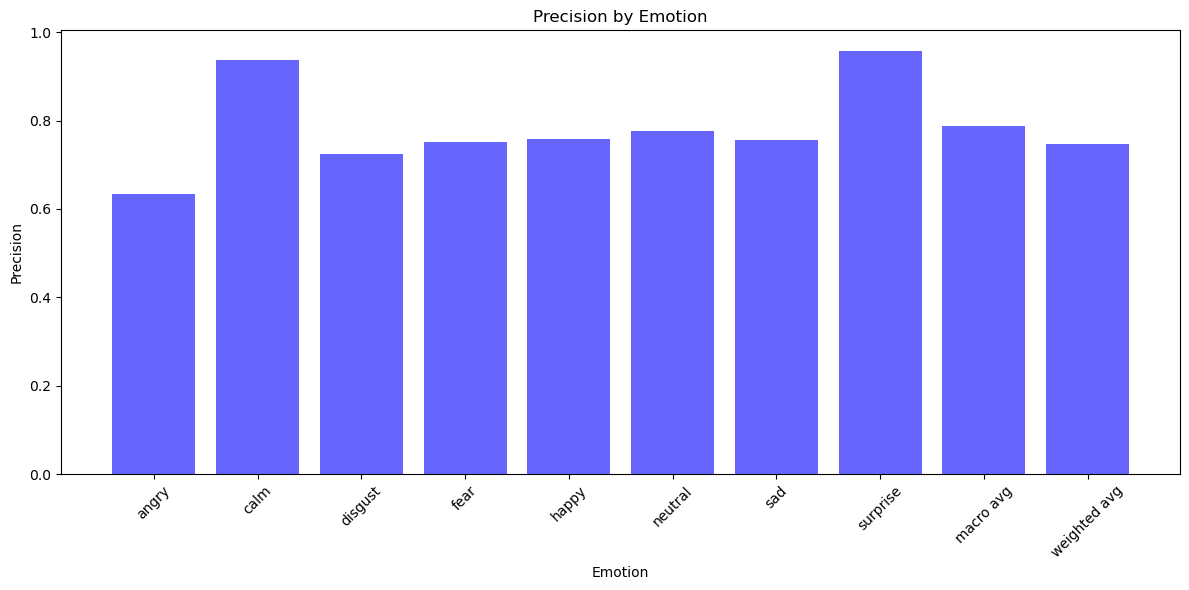

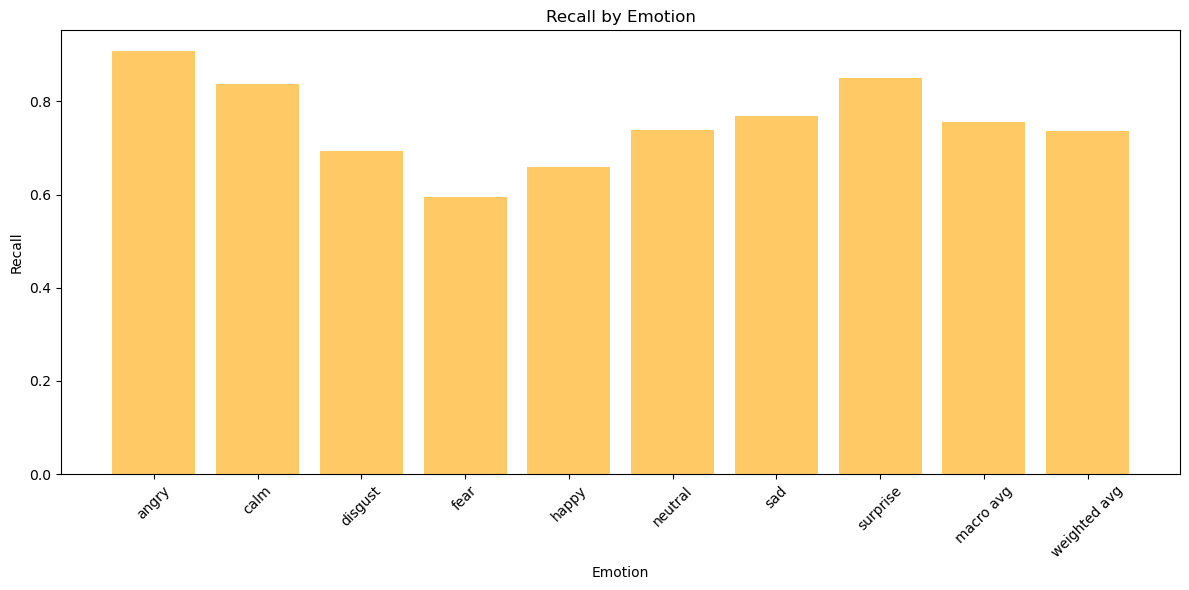

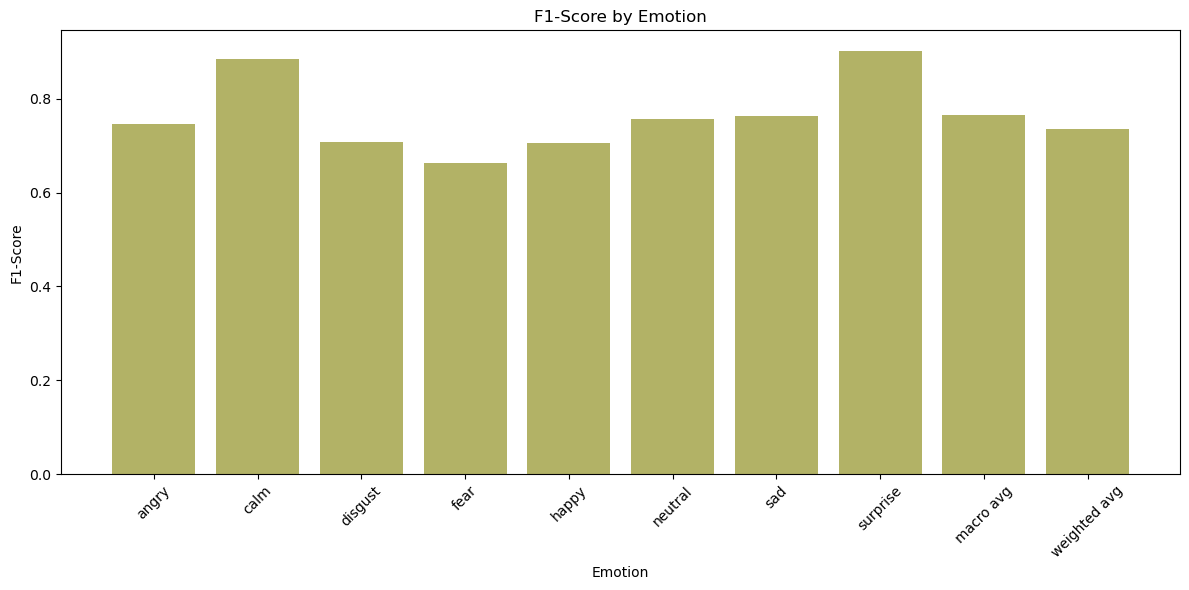

In [15]:
report = classification_report(y_test, y_pred, output_dict=True)
emotion_data = {
    "emotion": [],
    "precision": [],
    "recall": [],
    "f1-score": [],
    "support": []
}

for emotion, metrics in report.items():
    if isinstance(metrics, dict):
        emotion_data["emotion"].append(emotion)
        emotion_data["precision"].append(metrics.get("precision", 0))
        emotion_data["recall"].append(metrics.get("recall", 0))
        emotion_data["f1-score"].append(metrics.get("f1-score", 0))
        emotion_data["support"].append(metrics.get("support", 0))

df = pd.DataFrame(emotion_data)

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(df['emotion'], df['precision'], color='blue', alpha=0.6)
ax.set_xlabel('Emotion')
ax.set_ylabel('Precision')
ax.set_title('Precision by Emotion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting recall
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(df['emotion'], df['recall'], color='orange', alpha=0.6)
ax.set_xlabel('Emotion')
ax.set_ylabel('Recall')
ax.set_title('Recall by Emotion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting F1-score
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(df['emotion'], df['f1-score'], color='olive', alpha=0.6)
ax.set_xlabel('Emotion')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score by Emotion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
report = classification_report(y_test, y_pred, output_dict=True)
report

{'angry': {'precision': 0.6342376052385407,
  'recall': 0.9070234113712374,
  'f1-score': 0.7464905037159373,
  'support': 1495},
 'calm': {'precision': 0.9365079365079365,
  'recall': 0.8368794326241135,
  'f1-score': 0.8838951310861424,
  'support': 141},
 'disgust': {'precision': 0.7246904588492352,
  'recall': 0.6924147529575505,
  'f1-score': 0.708185053380783,
  'support': 1437},
 'fear': {'precision': 0.7515865820489573,
  'recall': 0.5938395415472779,
  'f1-score': 0.6634653861544617,
  'support': 1396},
 'happy': {'precision': 0.7575757575757576,
  'recall': 0.6593014967925873,
  'f1-score': 0.705030487804878,
  'support': 1403},
 'neutral': {'precision': 0.7765869744435284,
  'recall': 0.7394034536891679,
  'f1-score': 0.7575392038600723,
  'support': 1274},
 'sad': {'precision': 0.7559523809523809,
  'recall': 0.769179004037685,
  'f1-score': 0.762508338892595,
  'support': 1486},
 'surprise': {'precision': 0.9564220183486238,
  'recall': 0.8510204081632653,
  'f1-score': 0.